<img src="pyrho_logo.jpg" width=450>
<p style="text-align: center; font-family: Comfortaa; font-size: 32px">DFT for the rest of us.</p>
<p style="text-align: center; font-size: 48px">[Tutorial Notebook]</p>

# Introduction

In the last few decades, thousands of Ph.D.'s have been given to hard-working theoreticians who solved complex scientific problems using density functional theory (DFT) codes that they don't really understand. We built `pyrho`-- a real-space, python-based DFT code-- to make the "under-the hood" foundation for most DFT codes accessible to those of us who aren't brave enough to dive into production-level DFT software packages.

In this tutorial notebook, you will be guided through the process of building `pyrho` from scratch (starting with the 1D Schroedinger equation). To be as nimble and powerful as possible, `pyrho` makes heavy use of numerical recipes and routines in the `numpy` and `scipy` libraries. A working knowledge of the python language and these numerical libraries will therefore be very useful, but not strictly necessary. Along the way, we will make brief remarks about the usage of many important routines and do our best to visualize important features graphically with `matplotlib`.

Happy calculating!

-the pyrho team

# Required Packages
Try running the cell below (shift + enter). If any of the packages cannot be imported, you will need to install it before you can complete this tutorial. Some of the packages, namely `matplotlib` and `skimage`, are just there to help us visualize 2D and 3D data, so they are not technically required (but will be very helpful).

In [333]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.sparse.linalg import eigsh, LinearOperator
from scipy.spatial.distance import cdist
from scipy.stats import norm
from skimage.measure import marching_cubes_lewiner

## 1. Let's create a python class that can solve the 1D Schroedinger equation for an arbitrary potential shape any number of excited states.

We'll start with the very famous (time-independent) Schroedinger equation, $\hat{H}\Psi = E\Psi$, where the hamiltonian $\hat{H}$ is an operator that has both a kinetic contribution, which we calculate using the laplace operator $-\frac{1}{2}\nabla^2$, and a potential contribution $V_{pot}$, which is defined by some external potential. To get started, we can define any arbitrary shape for this potential, and we usually start with a step function (aka particle-in-a-box). Later on, this potential will be dictated by an atomic configuration (represented as pseudopotentials), and even later the potential will be modified by a charge density (which we will calculate self-consistently).

First, we initialize the class with its necessary attributes:

- `resolution` (int): the number of mesh points on which we will numerically store our potentials and hamiltonian.
- `x_max` (float or int): the maximum grid point.
- `x` and `dx` (float, float): the actual grid points on the 1D mesh defined by `resolution`, as well as their spacing from one another. These are created inside the class automatically based on `resolution` and `x_max`.
- `potential` (fun): the potential to use for $V_{pot}$, as a python function without parentheses, e.g. `np.sin`.
- `scale` (float or int): A scalar by which to scale `potential`.
- `n_states` (int): the number of eigenstates we will solve for.

Then we create a `get_laplacian()` method, which operates on a wave function `psi` and returns the kinetic energy contribution to $\hat{H}$. The laplacian

`get_hamiltonian()` simply combines the above two methods to return $\hat{H}$, which you will recall is equal to $-\frac{1}{2}\nabla^2 + V_{pot}\Psi$.

The real magic here is happening in the next function, `solve()`. Here, we use the `LinearOperator` object imported from `scipy.sparse.linalg` to represent our hamiltonian as a sparse matrix. Under the hood, this object is initializing a random `psi` whose dimensions are specified by `self.resolution`, and then using the `get_hamiltonian()` function to iteratively minimize the residual between $\hat{H}\Psi$ and the expectation value given by $E\Psi$.

In [334]:
class Schroedinger_1D:
    def __init__(self, x_max=np.pi, resolution=100, potential=np.sin, scale=-20, n_states=5):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.n_states = n_states
            
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) + np.roll(psi, -1) - 2 * psi) / self.dx**2        

    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential * psi
    
    def solve(self):
        A = LinearOperator((self.resolution,self.resolution), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T

    def plot(self):
        ax = plt.figure().gca()
        ax.plot(self.x, self.potential, 'k')
        for i in range(self.n_states):
            ax.plot(self.x, self.eigenvectors[i]*8 + self.eigenvalues[i])
            ax.plot(self.x, self.eigenvectors[i]*0 + self.eigenvalues[i], 'k--')
        plt.show()

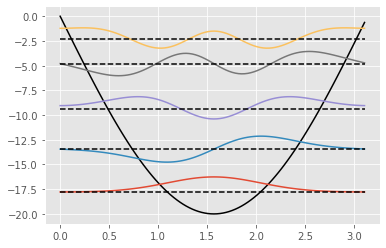

In [335]:
my_schroedinger = Schroedinger_1D()
my_schroedinger.solve()
my_schroedinger.plot()

## 2D Schroedinger equation

Now that we have a solution for the 1D Schroedinger equation, let's expand into the other dimensions as well. The beauty of using python classes is that in orfer to go from 1D --> 2D, we only need to change a few lines of code.

In [336]:
class Schroedinger_2D:
    def __init__(self, x_max=np.pi, resolution=100, potential=np.sin, scale=-20, n_states=5):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.xx, self.yy = np.meshgrid(self.x, self.x)
        self.potential = scale * potential(self.xx) * potential(self.yy)
        self.n_states = n_states
            
    def get_laplacian(self, psi):
        psi = np.reshape(psi, (self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) -
                4 * psi) / self.dx**2).ravel()

    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential.ravel() * psi
    
    def solve(self):
        A = LinearOperator((self.resolution**2, self.resolution**2), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T

    def plot(self):
        fig, ax = plt.subplots(nrows=1, ncols=self.n_states, figsize=(15, 5))
        for i in range(self.n_states):
            ax[i].imshow(np.reshape(self.eigenvectors[i], (self.resolution, self.resolution)), cmap=plt.cm.coolwarm)
        plt.show()

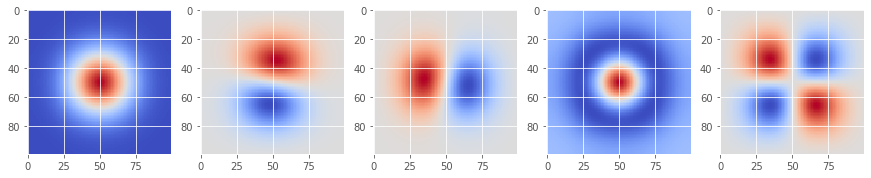

In [337]:
my_schroedinger = Schroedinger_2D()
my_schroedinger.solve()
my_schroedinger.plot()

## 3D Schroedinger equation

Similarly, to extend to 3 dimensions is also straighforward. Don't worry too much about the crazy plotting statements below- plotting with matplotlib in 3D is not always straightforward.

In [338]:
class Schroedinger_3D:
    def __init__(self, x_max=np.pi, resolution=30, potential=np.sin, scale=-30, n_states=5):
        self.resolution = resolution
        self.n_mat = resolution**3  # Stored as a variable to save us some computation
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.x, self.x)
        self.potential = scale * potential(self.xx) * potential(self.yy) * potential(self.zz)
        self.n_states = n_states
        
    def get_laplacian(self, psi):
        psi = np.reshape(psi, (self.resolution, self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                 np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) +
                 np.roll(psi, 1, axis=2) + np.roll(psi, -1, axis=2) +
                - 6 * psi)/self.dx**2).ravel()        
    
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential.ravel() * psi
    
    def solve(self):
        A = LinearOperator((self.n_mat, self.n_mat), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = [np.reshape(ev, (self.resolution, self.resolution, self.resolution))
                             for ev in eigenvectors.T]
        
    def plot(self):
        fig = plt.figure(figsize=(15, 15/self.n_states))
        for i in range(self.n_states):
            v = self.eigenvectors[i]
            ax = fig.add_subplot(1, self.n_states, i+1, projection='3d')
            if i == 0: # i.e. there are no negative values
                verts, faces, normals, values = marching_cubes_lewiner(v, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1)
            else:
                level1, level2 = max(v.ravel())*0.2, min(v.ravel())*0.2                
                verts, faces, normals, values = marching_cubes_lewiner(v, level=level1, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1)
                verts, faces, normals, values = marching_cubes_lewiner(v, level=level2, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1)
        plt.show()

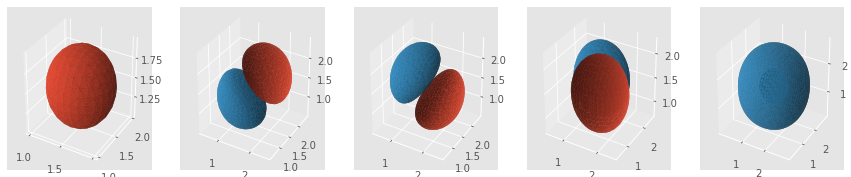

In [339]:
my_schroedinger = Schroedinger_3D(n_states=5)
my_schroedinger.solve()
my_schroedinger.plot()

Now we have the exact ground states and excited states for a one-particle system. But in the real world, electrons interact not only with an external potential (like the sinusoid we created above), but also with other electrons. Solving the shape of the potential that arises from these interactions in realistic systems ($N_e ~= 10^{23}$) quickly becomes an unsolvable problem (the many-body problem). Hoehenberg and Sham proposed that we can get around this problem by treating a system of interacting electrons as a system of non-interacting electrons, but where each electron sees an *effective* potential which accounts for the many-body interactions. Kohn and Sham later proved that we can rewrite the Schroedinger equation as

<center>
    $\hat{H}_{ks}(r)\psi_i(r) = \epsilon_i\psi_i(r)$
<\center>

where $\psi_i(r)$ are the orbitals of each non-interacting electron, $\epsilon_i$ are their corresponding eigenvalues, and $\hat{H}_{KS}$ is the new effective Hamiltonian. $\hat{H}_{ks}(r)$ looks very much the same as the Hamiltonian above:

<center>
    $\hat{H}_{ks}(r) = -\frac{1}{2}\nabla^2 + \nu_{ks}(r)$
<\center>
    
The kinetic (Laplacian) component stays in principle the same- there is no reason for this to change. You will notice that the real difference is that we've replaced $V_{pot}$ with $\nu_{ks}(r)$, where now

<center>
    $\nu_{ks}(r) = \nu_{ext}(r) + \nu_{H}(r) + \nu_{xc}(r)$.
<\center>

    
Let's look at the 3 components of $\nu_{ks}(r)$:
- $\nu_{ext}(r)$ is an external potential, exactly analogous to the simple $V_{pot}$ potentials we've been using up to this point. The shape of this potential arises from the electron's interaction with positively charged nuclei in the system:


<center>
    $$\nu_{ext}(r) = \sum_i^N{\frac{Z_i}{|r-R_i|}}$$
<\center>

- $\nu_{H}(r)$ is called the Hartree potential- this term gives us the repulsive interaction between the negatively charged electron density and itself. This can be calculated as the Coulombic interaction of each point $r$ with each other point $r^\prime$ in the density:

<center>
    $\nu_{H}(r) = q^2\int{d^3r^\prime\frac{n(r^\prime)}{|r-r^\prime|}}$
<\center>

Or, more efficiently, $\nu_{H}(r)$ can be solved using Poisson's equation
    
<center>
    $\nabla^2\nu_{H}(r) = 4\pi~n(r)$
<\center>
    
- $\nu_{xc}(r)$ is the exchange-correlation potential, whose form is not known and must be approximated. The most famous approximations to this potential tell us that $\nu_{xc}(r)$ is (more or less) a function of the local density (the so-called local density approximation, LDA) or its derivatives (generalized gradient approximation, GGA). In the local density approximation, we say
    
<center>
    $\nu_{xc}(r) = \frac{\delta\epsilon^{hom}_{xc}(n(r))}{\delta~n(r)}$
<\center>

Clearly, we need a density $n(r)$ before we can calculate $\nu_{ks}$. But to obtain $n(r)$, one technically needs the wavefunctions $\psi_i(r)$ in the relation
    
<center>
    $$n(r) = \sum_{i=1}^{N}|\psi_i(r)|^2$$
<\center>
    
and the Kohn Sham wavefunctions, $\psi_i(r)$ cannot be determined until we have the full Hamiltonian, which means we need $\nu_{ks}$.
    
One quickly notices that we have a circular problem- $\nu_{ks}(r)$ depends on $n(r)$, which depends on $\psi_i(r)$, which depends again on $\nu_{ks}(r)$. This non-linear problem must be solved *self-consistently*.

We start by initializing a trial density, $n_0(r)$, and using this density to obtain $\hat{H}_{ks}$, and using this Hamiltonian to obtain wavefunctions, $\psi_i(r)$. From these wave functions, we can calculate the total energy as
    
$$E_{ks} = \sum_{i=1}^{N}{\epsilon_i} + \int{\nu_{ext}(r)\rho(r)dr} + \int{\nu_{H}(r)\rho(r)dr} + \int{\nu_{xc}(r)\rho(r)dr}$$

Let's call the change in this energy between self-consistent steps $\Delta~E$. The more realistic our starting guess for $n_0(r)$ is, the faster we will converge $\Delta~E$. In practice, one of the most popular choices for $n_0(r)$ is to use a *linear combination of atomic orbitals* (LCAO). In this scheme, $n_0(r)$ is simply a linear combination of the electron densities of neutral, non-interacting atoms centered where the system's nuclei are.
    
In the block below, we will create $n_0(r)$ using something like an LCAO scheme, where we will model a simple cubic structure with atomic charge densities estimated as 3D gaussians.

In [539]:
class Pyrho:
    def __init__(self, resolution=10, x_max=10, n_states=10, atoms={}, max_steps=150, convergence_threshold=1e-4):
        self.resolution = resolution
        self.shape = (resolution, resolution)
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.n_mat = resolution**2
        self.xx, self.yy = np.meshgrid(self.x, self.x)
        self.mesh = np.array(list(zip(self.xx.ravel(), self.yy.ravel())))
        self.distance_matrix_ee = cdist(self.mesh, self.mesh)
        self.distance_matrices_en = []
        for atom in atoms:
            self.distance_matrices_en.append([np.linalg.norm(pt-atoms[atom]["coords"])+0.2 for pt in self.mesh])
        self.E = 0
        self.rho = np.zeros(self.shape)
        self.v_ext = np.zeros(self.shape)
        self.v_H = np.zeros(self.shape)
        self.v_xc = np.zeros(self.shape)
        self.eigenvectors, self.eigenvalues = None, None
        self.n_states = n_states
        self.max_steps = max_steps
        self.convergence_threshold = 1e-4
        self.atoms = atoms

    def get_laplacian(self, psi):
        psi = np.reshape(psi, (self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                 np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) -
                 4 * psi)/self.dx**2).ravel()    
        
    def get_gaussian_donut(self, mean):
        return (norm.pdf(self.xx, mean[0], 1) *
                norm.pdf(self.yy, mean[1], 1) *
                (np.power(self.xx-mean[0], 2) +
                np.power(self.yy-mean[1], 2)))

    def update_rho(self):
        self.rho = np.zeros(self.shape)
        if self.eigenvectors:
            for n in range(self.n_states):
                self.rho += np.power(self.eigenvectors[n], 2)
        else:
            for atom in self.atoms:
                self.rho += self.atoms[atom]["Z"] * self.get_gaussian_donut(self.atoms[atom]["coords"])            

    def update_v_ext(self):
        self.v_ext = np.zeros(self.shape)
        i = 0
        for atom in self.atoms:
            coulomb = np.divide(self.atoms[atom]["Z"], self.distance_matrices_en[i])
            self.v_ext += coulomb.reshape((self.resolution, self.resolution))
            i += 1

    def update_v_H(self):
        v_H = np.zeros(self.n_mat)
        rho = self.rho.ravel()
        for i in range(self.n_mat):
            for j in range(self.n_mat):
                if i != j:
                    v_H[i] += 0.5 * np.divide(rho[j], self.distance_matrix_ee[i][j])
        self.v_H = v_H.reshape((self.resolution, self.resolution))

    def update_v_xc(self):
        self.v_xc = np.zeros(self.shape)

    def update_v_all(self):
        self.update_v_ext()
        self.update_v_H()
        self.update_v_xc()
    
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + (self.v_ext.ravel() + self.v_H.ravel() + self.v_xc.ravel()) * psi

    def update_wavefunctions(self):
        A = LinearOperator((self.n_mat, self.n_mat), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = [np.reshape(ev, (self.resolution, self.resolution))
                             for ev in eigenvectors.T]

    def get_kinetic_energy(self):
        ke = 0
        for i in range(self.n_states):
            ke -= np.sum(self.get_laplacian(self.eigenvectors[i]))
        return ke
        
    def get_ext_energy(self):
        return np.sum(self.rho.ravel() * self.v_ext.ravel())

    def get_hartree_energy(self):
        return np.sum(self.rho.ravel() * self.v_H.ravel())
        
    def get_xc_energy(self):
        return -0.75 * np.power(3./np.pi, 1./3.) * np.sum(np.power(self.rho, 4./3.))
        
    def update_energy(self):
#        print(self.get_kinetic_energy(), self.get_ext_energy(), self.get_hartree_energy())
        self.E = (self.get_kinetic_energy() + self.get_ext_energy() +
                  self.get_hartree_energy() + self.get_xc_energy())
    
    def sc_minimize(self):
        self.update_rho()
        self.update_v_all()
        print("n E dE")
        for i in range(self.max_steps):
            previous_E = self.E
            self.update_wavefunctions()
            self.update_rho()
            self.update_v_all()
            self.update_energy()
            print(i+1, self.E, abs(self.E - previous_E))
            if abs(self.E - previous_E) < self.convergence_threshold:
                break
        else:
            print("WARNING: Convergence was never reached.")
            
    def plot(self, attribute):
        ax = plt.figure().gca()
        ax.imshow(attribute)
        plt.show()

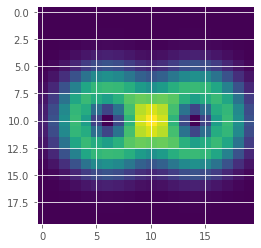

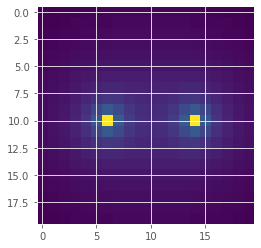

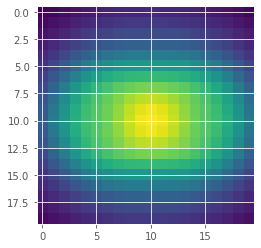

In [540]:
atoms = {"H1": {"Z": 1, "coords": (3, 5)}, "H2": {"Z": 1, "coords": (7, 5)}}
pyrho = Pyrho(resolution=20, atoms=atoms, max_steps=10)
pyrho.update_rho()
pyrho.plot(pyrho.rho)
pyrho.update_v_ext()
pyrho.plot(pyrho.v_ext)
pyrho.update_v_H()
pyrho.plot(pyrho.v_H)
pyrho.update_wavefunctions()
pyrho.update_energy()
# pyrho.update_rho()
# pyrho.plot(pyrho.rho)
# pyrho.sc_minimize()
# pyrho.plot(pyrho.rho)

In [541]:
pyrho.sc_minimize() # this, obviously, does not work yet.

n E dE
1 16.59664470407937 42.7774039479923
2 15.377444846104423 1.2191998579749477
3 16.059233132470762 0.6817882863663396
4 15.597311602483261 0.46192152998750124
5 15.907295470054047 0.3099838675707858
6 15.695873738420026 0.21142173163402056
7 15.84220123510898 0.14632749668895428
8 15.731745881065157 0.11045535404382356
9 15.816701510759266 0.08495562969410919
10 15.745126125773561 0.07157538498570482


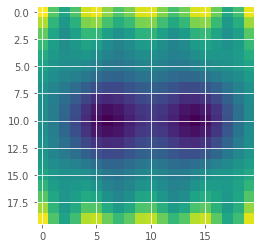

In [543]:
pyrho.plot(pyrho.rho)